<a href="https://colab.research.google.com/github/yeesem/Soft-Computing/blob/main/Soft_Computing_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpimg
import zipfile
import os

In [ ]:
# Doest work
# !wget https://github.com/yeesem/Machine-Learning-Datasets/blob/main/Jute%20Pest%20Dataset.zip

--2024-04-18 15:15:34--  https://github.com/yeesem/Machine-Learning-Datasets/blob/main/Jute%20Pest%20Dataset.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Jute Pest Dataset.zip.2’

Jute Pest Dataset.z     [ <=>                ] 147.04K  --.-KB/s    in 0.009s  

2024-04-18 15:15:35 (15.9 MB/s) - ‘Jute Pest Dataset.zip.2’ saved [150565]



In [ ]:
zip_file_name = "/content/Jute Pest Dataset.zip"
zip_ref = zipfile.ZipFile(zip_file_name,'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
# Assign the training and validation set directories
base_dir = '/content/jute_insect_data_all'

train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')

full_form_insect = os.listdir(train_dir)
short_form_insect = [''.join([item[0].lower() for item in name.split(" ")]) for name in full_form_insect]
insect_type_dict = {}

train_dirs = {}
validation_dirs = {}

for insect_type,insect_type_short_form in zip(full_form_insect,short_form_insect):
  insect_type_dict[insect_type_short_form] = insect_type
  train_dirs[insect_type_short_form] = os.path.join(train_dir,insect_type)
  validation_dirs[insect_type_short_form] = os.path.join(validation_dir,insect_type)

In [ ]:
# Number of each training and validation set
for insect_short_form, dir in insect_type_dict.items():
  print(insect_type_dict[insect_short_form])
  print("Number of training sets   : ",len(os.listdir(train_dirs[insect_short_form])))
  print("Number of validation sets : ",len(os.listdir(validation_dirs[insect_short_form])))
  print('\n')

Spilosoma Obliqua
Number of training sets   :  220
Number of validation sets :  30


Jute Stem Weevil
Number of training sets   :  220
Number of validation sets :  30


Yellow Mite
Number of training sets   :  220
Number of validation sets :  30


Field Cricket
Number of training sets   :  220
Number of validation sets :  30




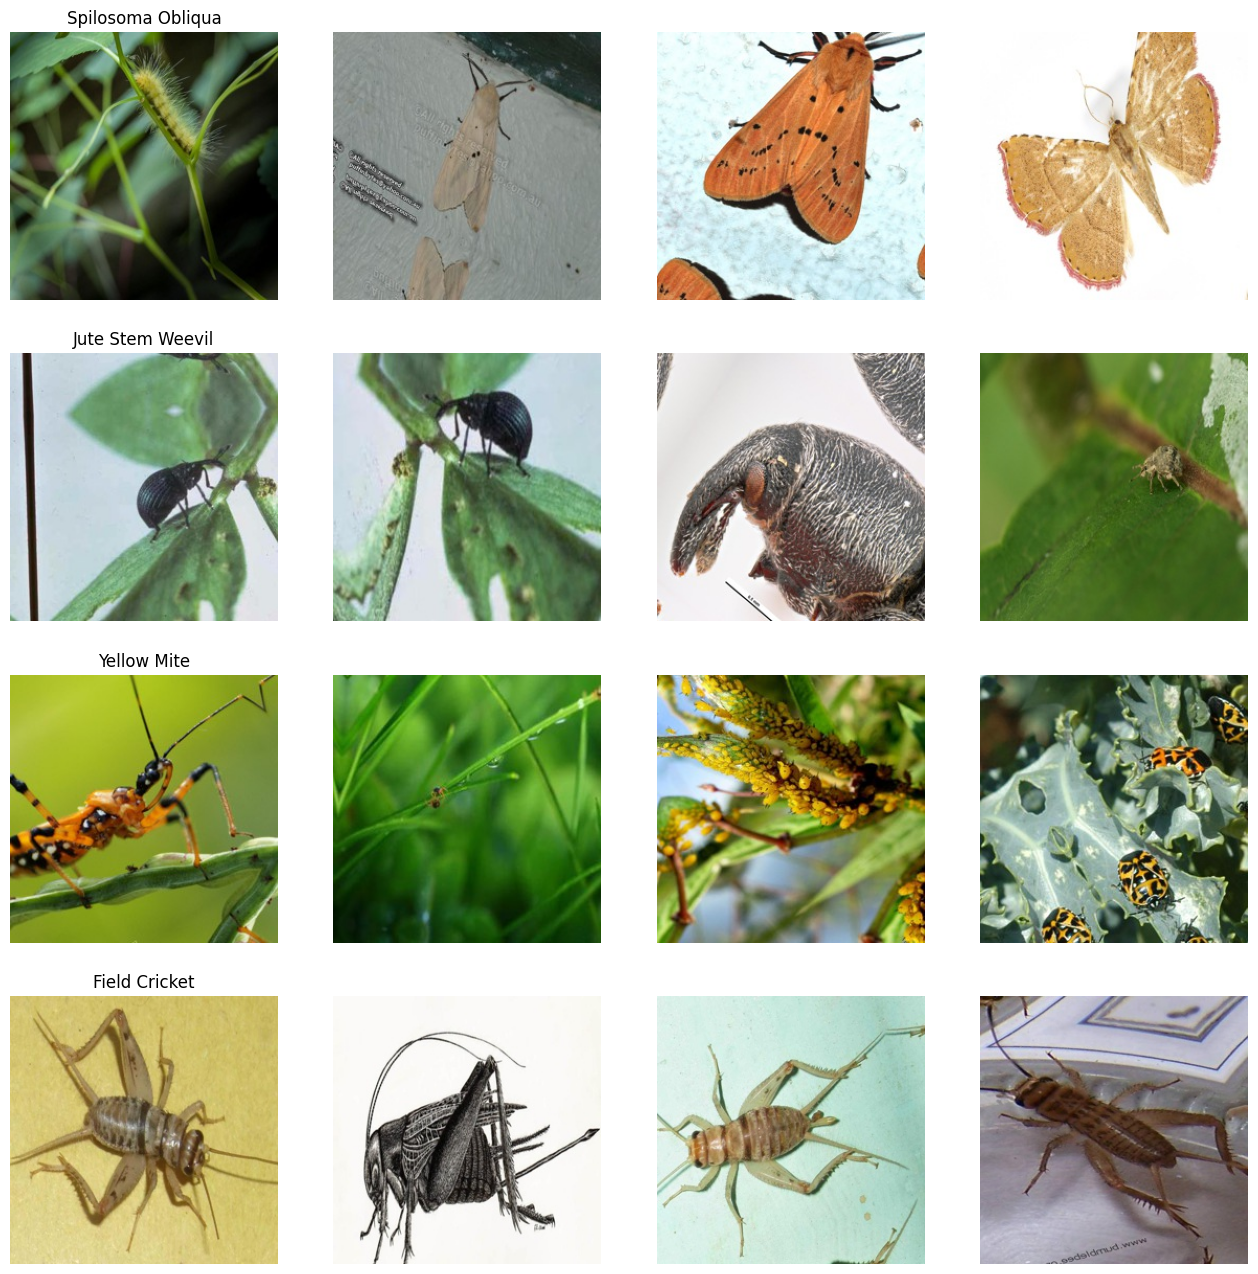

In [ ]:
# Set up matplotlib fig and size it to fit 4x4 pics
ncols = 4
nrows = 4
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4,nrows * 4)

pic_index += 4

insect_pix = []

for insect_type in train_dirs:
    insect_pix.extend(os.path.join(train_dirs[insect_type],fname)
                      for fname in os.listdir(train_dirs[insect_type])[pic_index-4:pic_index])

for i, img_path in enumerate(insect_pix):

  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows,ncols,i+1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

  # Add title for each row
  if i % ncols == 0:
      row_title_index = i // ncols
      plt.title(full_form_insect[row_title_index])

plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def DataGenerator(train_directory,validation_directory,DataAugmentation = False,size = 250):

  if DataAugmentation == False:
    train_datagen = ImageDataGenerator(rescale = 1./255)

  else:
    train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 40,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest'
    )

  test_datagen = ImageDataGenerator(rescale = 1./255)

  train_data_generator = train_datagen.flow_from_directory(
      train_directory,
      target_size = (size,size),
      batch_size = 16,
      class_mode = 'categorical'
  )

  test_data_generator = test_datagen.flow_from_directory(
      validation_directory,
      target_size = (size,size),
      batch_size = 4,
      class_mode = 'categorical'
  )

  return train_data_generator,test_data_generator

In [59]:
def create_model(size = 250,dropout = False, DROPOUT_RATE = 0.0):
  model = tf.keras.models.Sequential([
      # First Convolutional layer
      tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',input_shape = (size,size,3)),
      tf.keras.layers.MaxPooling2D((2,2)),
      # Second Convolutional layer
      tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
      tf.keras.layers.MaxPooling2D((2,2)),
      # Third Convolutional layer
      tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
      tf.keras.layers.MaxPooling2D((2,2)),
      # Forth Convolutional layer
      tf.keras.layers.Conv2D(128,(3,3),activation = 'relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      # Connected layer
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128,activation = 'relu'),
      tf.keras.layers.Dropout(DROPOUT_RATE) if dropout else tf.keras.layers.Dropout(0),
      tf.keras.layers.Dense(32,activation = 'relu'),
      tf.keras.layers.Dense(4,activation = 'softmax'),
  ])

  return model

In [60]:
def compile_model(model,loss = 'categorical_crossentropy',optimizer = tf.keras.optimizers.Adam,learning_rate = 0.0001):
  model.compile(
      loss = loss,
      optimizer = optimizer(learning_rate = learning_rate),
      metrics = ['accuracy']
  )

In [61]:
def fit_model(model,train_data_generator,validation_data_generator,num_epochs,verbose):
  history = model.fit(
      train_data_generator,
      epochs = num_epochs,
      steps_per_epoch = 55,
      validation_data = validation_data_generator,
      validation_steps = 30,
      verbose = verbose
  )

  return history

In [62]:
def plot_graphs(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss =  history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs,acc,'bo',label = 'Training Accuracy')
  plt.plot(epochs,val_acc,'r',label = 'Testing Accuracy')
  plt.title("Training and Testing Accuracy")
  plt.figure()

  plt.plot(epochs,loss,'bo',label = 'Training Loss')
  plt.plot(epochs,val_loss,'r',label = 'Testing Loss')
  plt.title("Training and Testing Loss")
  plt.legend()
  plt.show()

In [63]:
def train_model(train_dir,validation_dir,setting):

  TARGET_SIZE = setting[0]
  IMAGE_AUGMENTATION = setting[1]
  DROPOUT = setting[2]
  DROPOUT_RATE =setting[3]
  NUM_EPOCHS = setting[4]
  LEARNING_RATE = setting[5]
  OPTIMIZER = tf.keras.optimizers.Adam
  VERBOSE = 0

  # Image Generator
  train_generator,validation_generator = DataGenerator(train_dir,validation_dir,IMAGE_AUGMENTATION,TARGET_SIZE)

  # Create model
  model = create_model(TARGET_SIZE)

  # Compile model
  compile_model(model,optimizer = OPTIMIZER,learning_rate = LEARNING_RATE)

  # Train model
  history = fit_model(model,train_generator,validation_generator,NUM_EPOCHS,verbose = VERBOSE)

  # Plot Accuracy and Loss graph
  plot_graphs(history)

1  :  [150, False, False, 0, 50, 0.0001]


Found 880 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


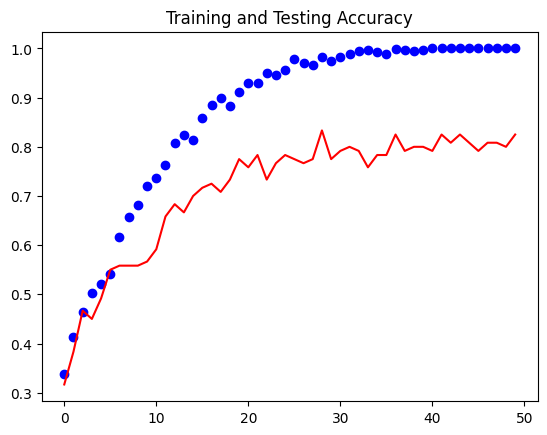

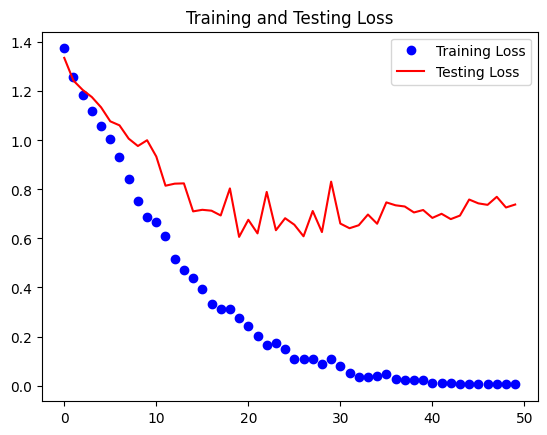




2  :  [150, True, False, 0, 50, 0.0001]


Found 880 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


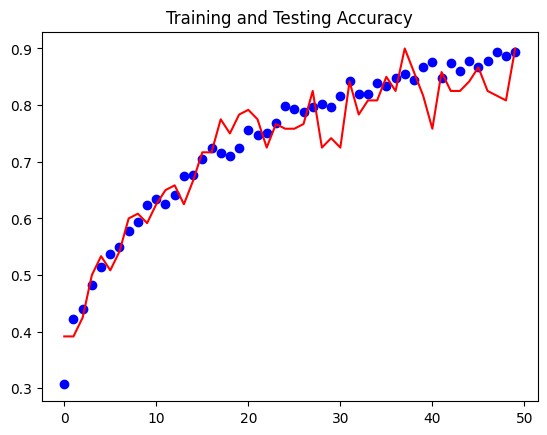

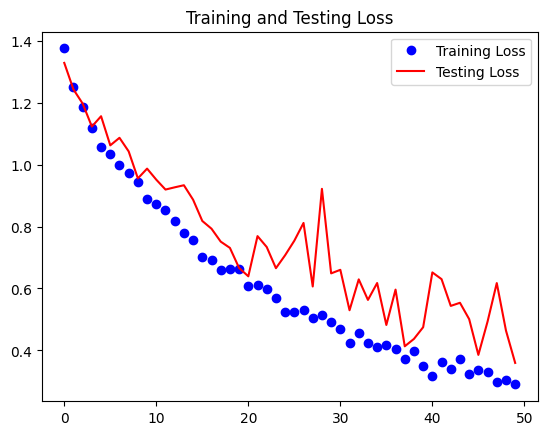




3  :  [150, True, True, 0.3, 50, 0.0001]


Found 880 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


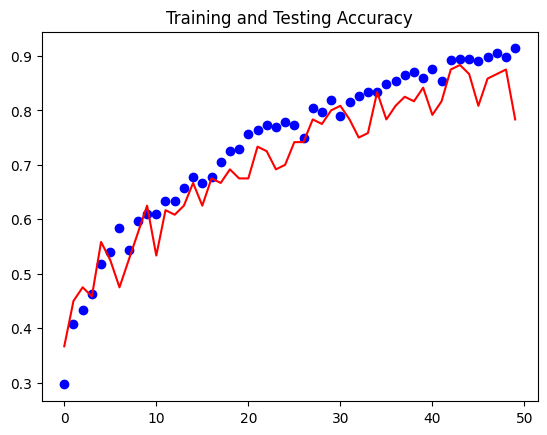

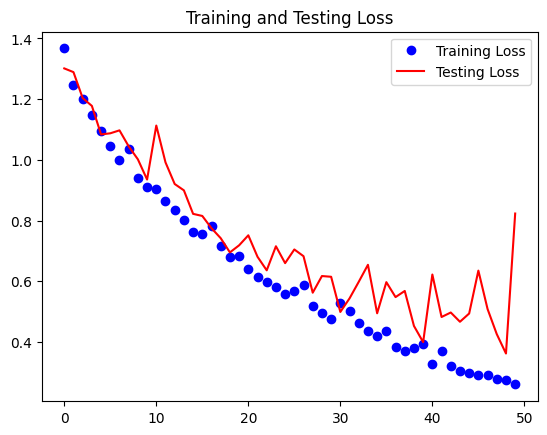




4  :  [300, True, False, 0, 50, 0.0001]


Found 880 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


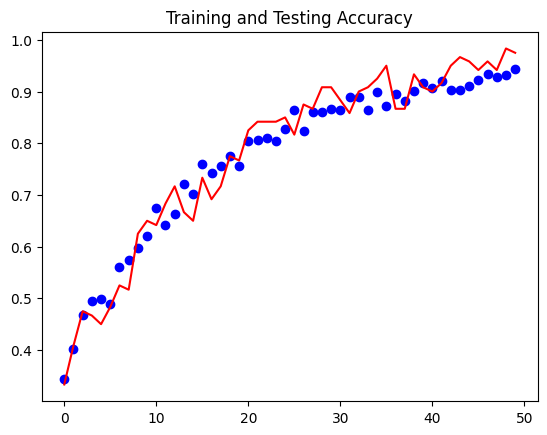

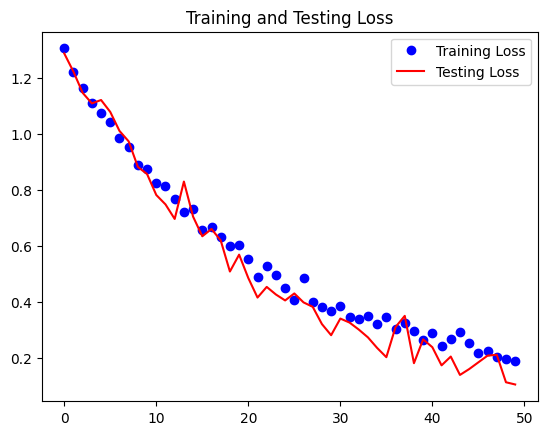




5  :  [300, True, True, 0.3, 50, 0.0001]


Found 880 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


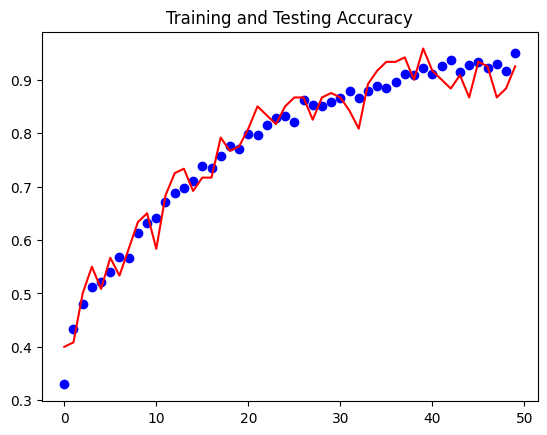

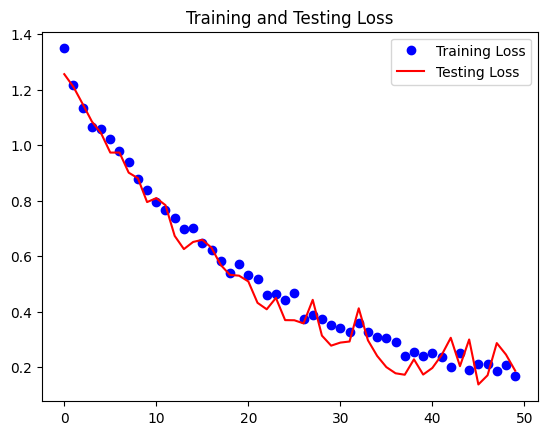

In [64]:
# TARGET_SIZE, IMAGE_AUGENTATION, DROPOUT, DROPOUT_RATE, NUM_EPOCHS, LEARNING_RATE
settings = [
    [150, False, False, 0,   50 ,0.0001],
    [150, True,  False, 0,   50 ,0.0001],
    [150, True,  True,  0.3, 50 ,0.0001],
    [300, True,  False, 0,   50 ,0.0001],
    [300, True,  True,  0.3, 50 ,0.0001]
]

for index,setting in enumerate(settings):
  print((index + 1)," : ",setting)
  print("\n")
  train_model(train_dir,validation_dir,setting)
  print("\n\n")

1  :  [150, False, False, 0.3, 50, 0.1]


Found 880 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


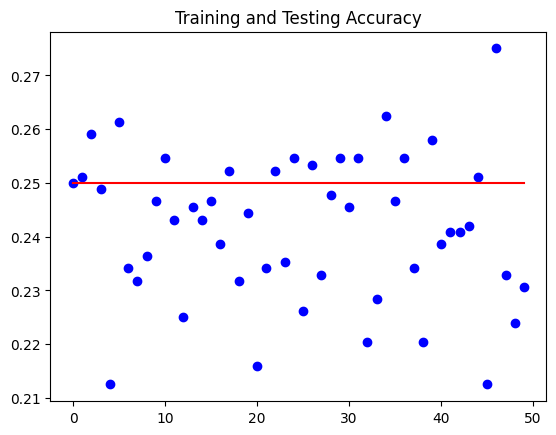

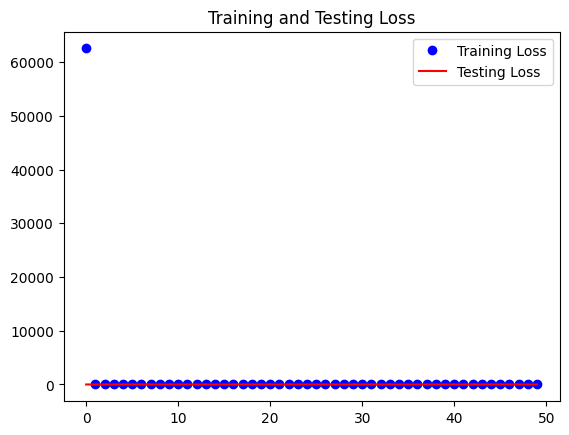




2  :  [150, False, True, 0.3, 50, 0.0001]


Found 880 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


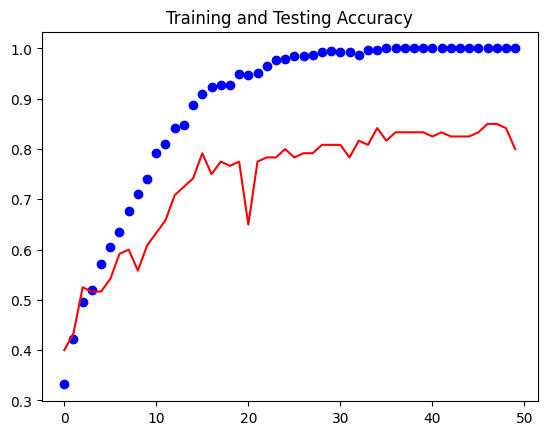

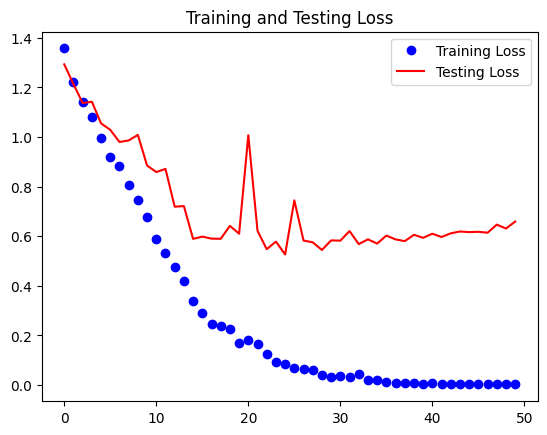




3  :  [300, False, False, 0.3, 50, 0.1]


Found 880 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


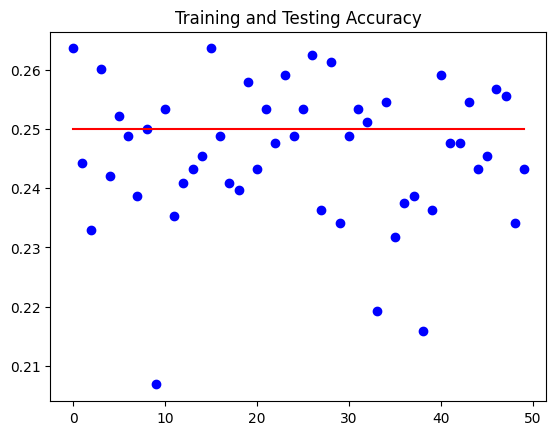

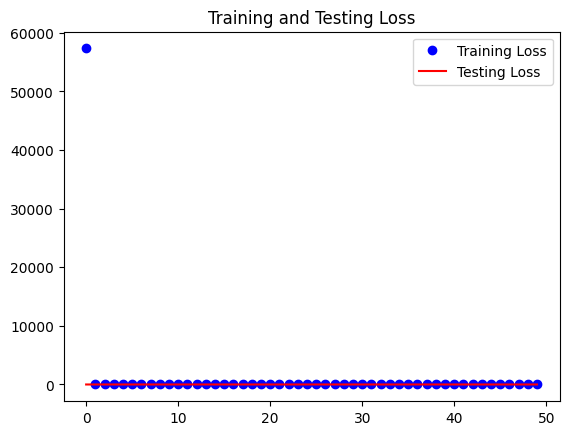




4  :  [300, False, True, 0.3, 50, 0.0001]


Found 880 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


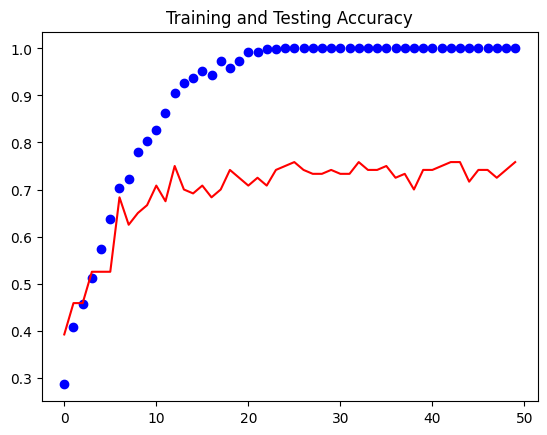

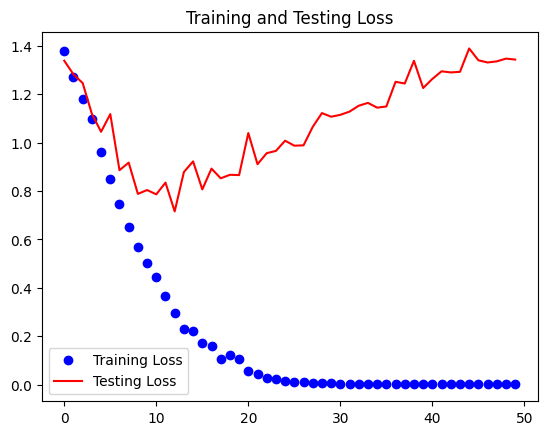

In [67]:
settings2 = [
    [150, False,  False, 0.3, 50 ,0.1],
    [150, False,  True,  0.3, 50 ,0.0001],
    [300, False,  False, 0.3, 50 ,0.1],
    [300, False,  True,  0.3, 50 ,0.0001],
    ]

for index,setting in enumerate(settings2):
  print((index + 1)," : ",setting)
  print("\n")
  train_model(train_dir,validation_dir,setting)
  print("\n\n")

In [ ]:
# train_model(train_dir,validation_dir,TARGET_SIZE)